
📅 Chargement des données :
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
['id', 'gender', 'age', 'hyp

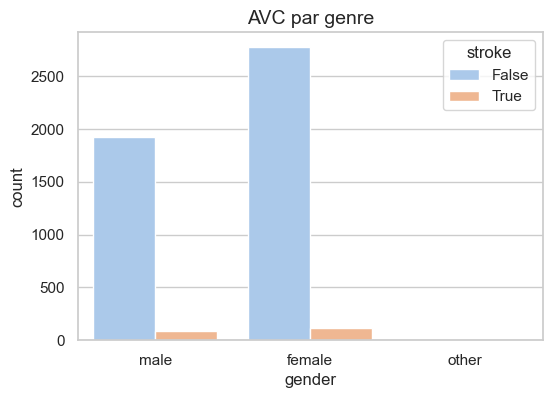

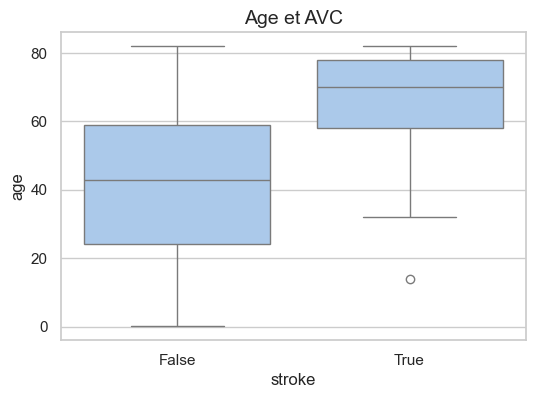

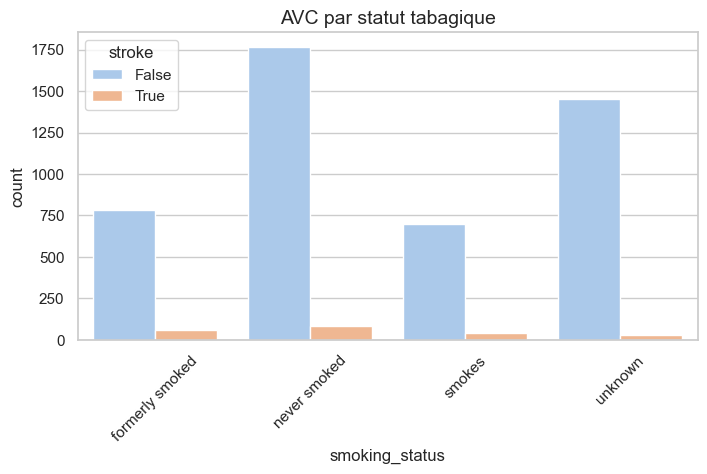

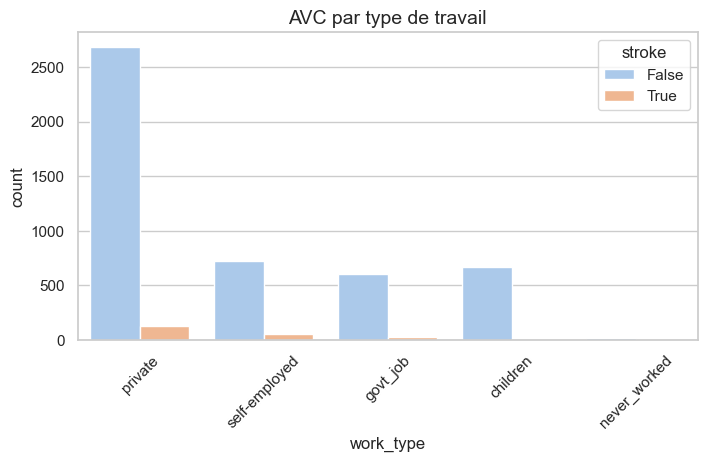

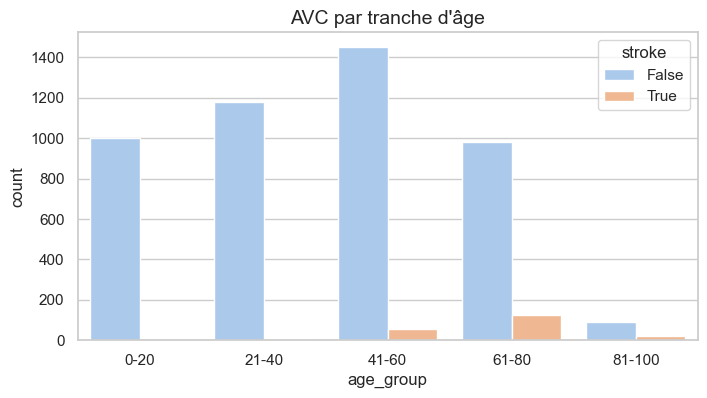

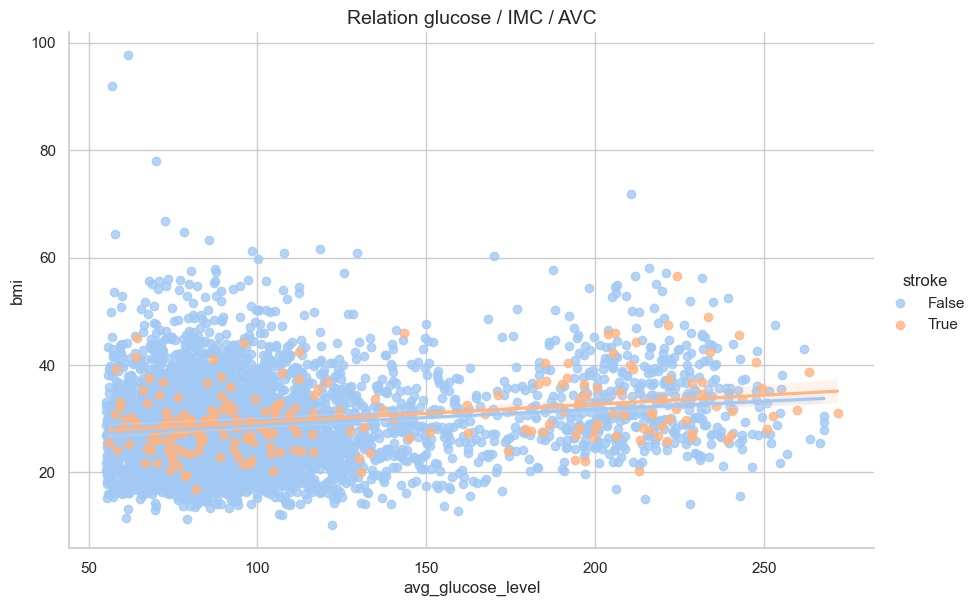

✅ Fichier CSV 'statistiques_avc.csv' exporté avec succès.

📃 Rapport :
Total patients : 4909
Nombre d'AVC : 209 (4.26%)


In [13]:
# -----------------------------------------------
# Analyse des données de santé — AVC (stroke)
# Projet pour le cours "Outils libres pour le développement logiciel"
# Master 1 Informatique - IED Paris 8
# -----------------------------------------------

# 1. 📚 Importation des bibliothèques
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import sql, Error

# Configuration des graphiques
sns.set(style='whitegrid', palette='pastel', rc={'axes.titlesize': 14, 'axes.labelsize': 12})
plt.rcParams['figure.dpi'] = 100

# 2. 📅 Chargement des données
print("\n📅 Chargement des données :")
df = pd.read_csv('D:/Healthcare/healthcare-dataset-stroke-data.csv')

# 3. 💡 Aperçu et infos
print(df.head())
print(df.columns.tolist())
df.info()

# 4. 🔍 Valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

# 5. 🧹 Nettoyage
print("\nNettoyage des données...")
df_clean = df.dropna(subset=['bmi']).copy()
df_clean.columns = df_clean.columns.str.strip().str.lower()

for col in ['gender', 'smoking_status', 'ever_married', 'work_type', 'residence_type']:
    df_clean[col] = df_clean[col].str.lower()

df_clean['hypertension'] = df_clean['hypertension'].astype(bool)
df_clean['heart_disease'] = df_clean['heart_disease'].astype(bool)
df_clean['stroke'] = df_clean['stroke'].astype(bool)

df_clean.reset_index(drop=True, inplace=True)
print(f"\n🧳 Total lignes nettoyées : {df_clean.shape[0]}")

# 6. 📂 Connexion PostgreSQL
try:
    conn = psycopg2.connect(
        dbname="stroke_db",
        user="postgres",
        password="root",
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()
    print("\n🚀 Connexion à PostgreSQL réussie.")

    # 7. 📤 Insertion de toutes les données (après TRUNCATE)
    cursor.execute("TRUNCATE TABLE patients;")
    for _, row in df_clean.iterrows():
        try:
            cursor.execute("""
                INSERT INTO patients (
                    gender, age, hypertension, heart_disease, ever_married,
                    work_type, residence_type, avg_glucose_level, bmi,
                    smoking_status, stroke
                ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """, (
                row['gender'], row['age'], row['hypertension'], row['heart_disease'],
                row['ever_married'], row['work_type'], row['residence_type'],
                row['avg_glucose_level'], row['bmi'], row['smoking_status'],
                row['stroke']
            ))
        except Error as e:
            print(f"Erreur d'insertion : {e}")

    conn.commit()
    print("\n🚜 Toutes les données ont été insérées avec succès.")

    # 8. 🔢 Requêtes SQL utiles
    print("\n🔢 Nombre total de patients :")
    cursor.execute("SELECT COUNT(*) FROM patients;")
    print(cursor.fetchone()[0])

    print("\n👩‍💻 Moyenne d'âge selon AVC :")
    cursor.execute("SELECT stroke, AVG(age) FROM patients GROUP BY stroke;")
    for r in cursor.fetchall():
        print(f"Stroke={r[0]} → Âge moyen = {r[1]:.2f} ans")

    cursor.close()
    conn.close()
except Error as e:
    print(f"Connexion ou exécution échouée : {e}")

# 9. 📊 Visualisations
# Tranche d'âge
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 20, 40, 60, 80, 100],
                               labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x='gender', hue='stroke')
plt.title('AVC par genre')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_clean, x='stroke', y='age')
plt.title("Age et AVC")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='smoking_status', hue='stroke')
plt.title('AVC par statut tabagique')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='work_type', hue='stroke')
plt.title('AVC par type de travail')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='age_group', hue='stroke')
plt.title("AVC par tranche d'âge")
plt.show()

sns.lmplot(data=df_clean, x='avg_glucose_level', y='bmi', hue='stroke', height=6, aspect=1.5)
plt.title("Relation glucose / IMC / AVC")
plt.show()


# 10. 📊 Statistiques + Export CSV (version sûre)
stats = df_clean.groupby('stroke')[['age', 'avg_glucose_level', 'bmi']].mean()

if not stats.empty:
    stats.to_csv("D:/Healthcare/statistiques_avc.csv")
    print("✅ Fichier CSV 'statistiques_avc.csv' exporté avec succès.")
else:
    print("⚠️ Aucun contenu à exporter (DataFrame vide).")


# 11. 📃 Rapport synthétique
print("\n📃 Rapport :")
print(f"Total patients : {len(df_clean)}")
print(f"Nombre d'AVC : {df_clean['stroke'].sum()} ({df_clean['stroke'].mean()*100:.2f}%)")

